# Libraries used

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data

In [2]:
global_all=sc.read_h5ad("/fast/AG_Huebner/huebner3/ANALYSES/20200706_el_COVID_Biopsy/data/global_annotated_20220308_vaccination_conditioncustom_NEW_20230820_RAW.h5ad")
global_all_clustered=sc.read_h5ad("/fast/AG_Huebner/huebner3/ANALYSES/20200706_el_COVID_Biopsy/data/global_annotated_20220308_vaccination_conditioncustom_NEW_20230820.h5ad")

In [ ]:
global_all=sc.read_h5ad("GLOBAL_RAW.h5ad")
global_all_clustered=sc.read_h5ad("GLOBAL.h5ad")

## Removal of unassigned states and endocardial cells to make controls and biopsies more comparable

In [3]:
global_all=global_all[global_all.obs.celltype_classified!="unassigned"]
global_all_clustered=global_all_clustered[global_all_clustered.obs.celltype_classified!="unassigned"]

In [4]:
global_all=global_all[global_all.obs.celltype_classified!="EC_PKHD1L1+"]
global_all_clustered=global_all_clustered[global_all_clustered.obs.celltype_classified!="EC_PKHD1L1+"]

## Define the color scheme

In [5]:
colorcode={'CM':'#E9791F',
           'FB':'#D92F2F',
           'EC':'#27A069',
           'Mural':'#D87AB2',
           'Myeloid':'#B6BD63',
           'Lymphoid':'#8A5EA8',
           'NC':'#18BDCF',
           'Mast':"#9D7167",
           'EC_PKHD1L1+':"#B1C7E7",
           'AD':"#4F96C4"
          }

# Functions

In [6]:
def gene_contribution(PATIENT, GOI, data=global_all):
    
    patient_data=global_all[global_all.obs.Patient==PATIENT]
    gene_counts_all=np.array((patient_data[:,GOI].X.todense()).flatten())[0]
    total_UMIs_gene=gene_counts_all.sum()
    total_nuclei=patient_data.shape[0]
    
    
    data = {'Cell_type': patient_data.obs.celltype_classified,
            'UMIs': gene_counts_all
           }
    df = pd.DataFrame(data)
    # Applying a function using groupby
    result = (df.groupby('Cell_type')['UMIs'].sum())/total_nuclei
    
    results={'Celltype':(result/total_UMIs_gene).index,
             'Contribution':(result/total_UMIs_gene).values,
             'Patient':PATIENT,
             'Condition':patient_data.obs.Condition_custom[1],
             #'total_UMI':total_UMIs_gene
            }
    results=pd.DataFrame(results)
    
    UMI_counts_total={'Patient':PATIENT,
                      'Condition':patient_data.obs.Condition_custom[1],
                      'total_UMI':total_UMIs_gene/total_nuclei
                     }
    #Total_UMI={'Patient':PATIENT,
    #                  'Condition':patient_data.obs.Condition_custom[1],
    #                  'nr_nuclei':patient_data.shape[0]
    #}
    
    return results, UMI_counts_total

In [9]:
GOI='IL16'

In [10]:
CT_counts=[gene_contribution(PATIENT, GOI, data=global_all)[0] for PATIENT in global_all.obs.Patient.unique()]
total_UMI=[gene_contribution(PATIENT, GOI, data=global_all)[1] for PATIENT in global_all.obs.Patient.unique()]

In [11]:
xx=CT_counts[0].append(CT_counts[1:])

In [12]:
total_UMI=pd.DataFrame(total_UMI).groupby('Condition').median()
total_UMI['total_UMI']=total_UMI['total_UMI']/total_UMI.loc['Control','total_UMI']

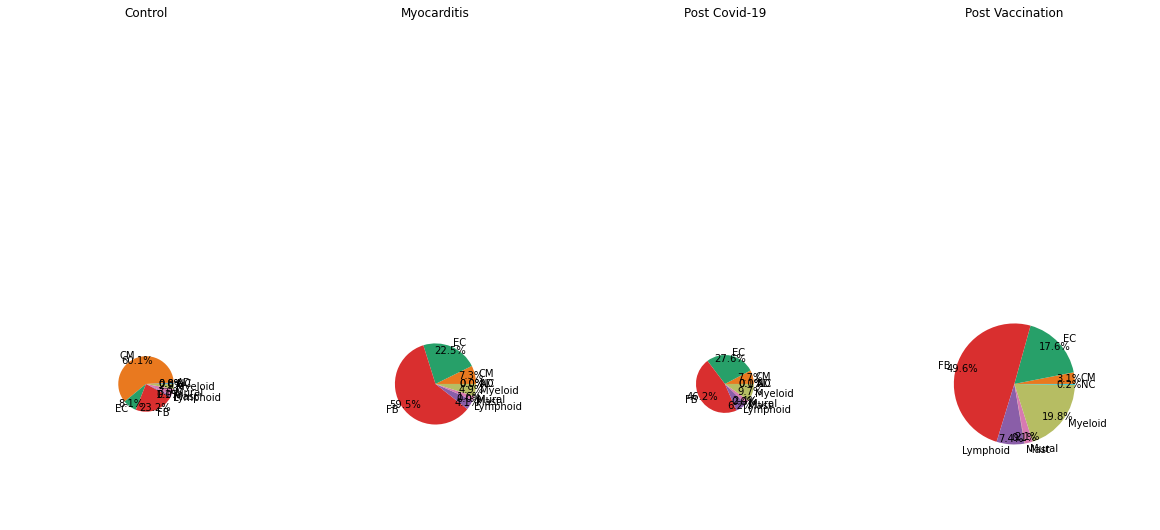

In [18]:
fig, axes = plt.subplots(1, 4, figsize=(16, 19), constrained_layout=True)

for i in range(4):
    #CONDITION=xx['Condition'].unique()[i]
    CONDITION=['Control', 'Myocarditis', 'Post Covid-19', 'Post Vaccination'][i]
    r=total_UMI.loc[CONDITION, 'total_UMI']
    
    x_cond_subset=xx[xx['Condition']==CONDITION]
    x_cond_subset_average=x_cond_subset.groupby('Celltype')['Contribution'].median()
    x_cond_subset_average=(x_cond_subset_average/x_cond_subset_average.sum())
    x_cond_subset_average=pd.DataFrame(x_cond_subset_average)
    
    colors=[colorcode[i] for i in x_cond_subset_average.index]
    
    
    axes[i].pie(x_cond_subset_average['Contribution'].values, 
                colors=colors,
           labels=x_cond_subset_average.index, 
           radius = r/4, autopct="%.1f%%", pctdistance=0.9)
    axes[i].set_title(CONDITION, y=1.8)

#plt.savefig("/fast/AG_Huebner/huebner3/ANALYSES/20200706_el_COVID_Biopsy/data_publication/Piecharts/" + GOI + ".pdf", format="pdf", bbox_inches="tight")
plt.show()